# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from Sampler import Sampler
from utility import *
from matplotlib.gridspec import GridSpec
import os

path = 'imgs/adult'

In [2]:
def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                    'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

## Dataset description

The [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/adult) contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [4]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
adult_df.shape

(30940, 15)

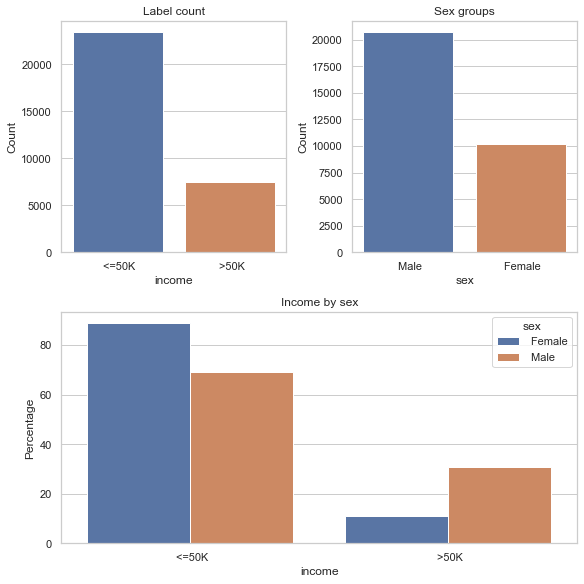

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
sns.barplot(x='income', y='percentage', 
            data=(adult_df[['sex','income']]
                  .groupby('sex')['income']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()),
            hue='sex', ax=ax3)
ax3.set(ylabel='Percentage', title="Income by sex")
sns.countplot(x='income', data=adult_df, ax=ax1)
sns.countplot(x='sex', data=adult_df, ax=ax2)

ax2.set(ylabel='Count', title="Sex groups")
ax1.set(ylabel='Count', title="Label count")
plt.savefig(os.path.join(path, 'adult_distr.pdf'))
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [7]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [8]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [9]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [10]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

## Bias Dataset

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8119
Statistical parity: -0.3550
Disparate impact: 0.2829
Average odds: -0.2238
Equal opportunity: -0.1971
Theil index: 0.0826


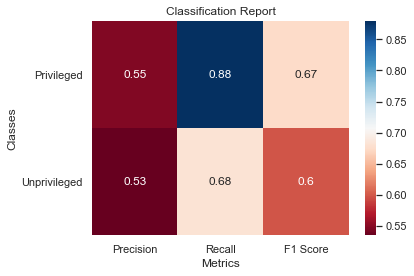

In [11]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    data, privileged_group, unprivileged_group)

## Reweighing

In [12]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8001
Statistical parity: -0.1907
Disparate impact: 0.5532
Average odds: -0.0309
Equal opportunity: 0.0314
Theil index: 0.0899


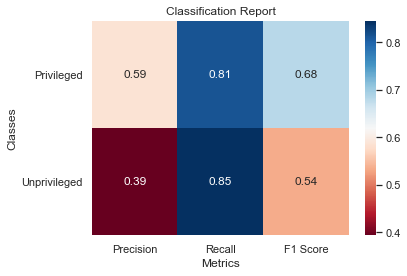

In [13]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

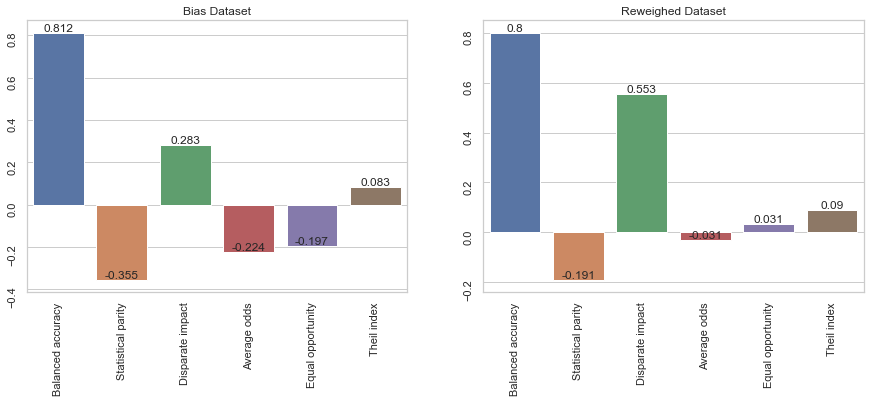

In [14]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [15]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

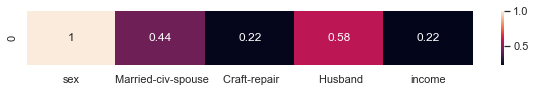

In [16]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

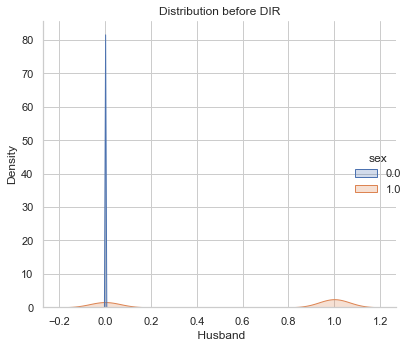

In [17]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_cat_bf.pdf')
plt.show()

Apply DIR and check correlation changes:

In [18]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


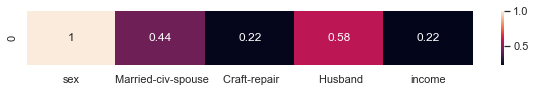

In [19]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


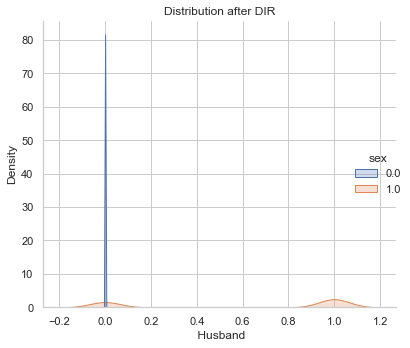

In [20]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.tight_layout()
plt.savefig('dir_cat_aft.pdf')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8103
Statistical parity: -0.3145
Disparate impact: 0.3505
Average odds: -0.1655
Equal opportunity: -0.1158
Theil index: 0.0829


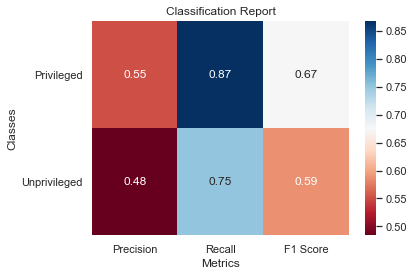

In [21]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


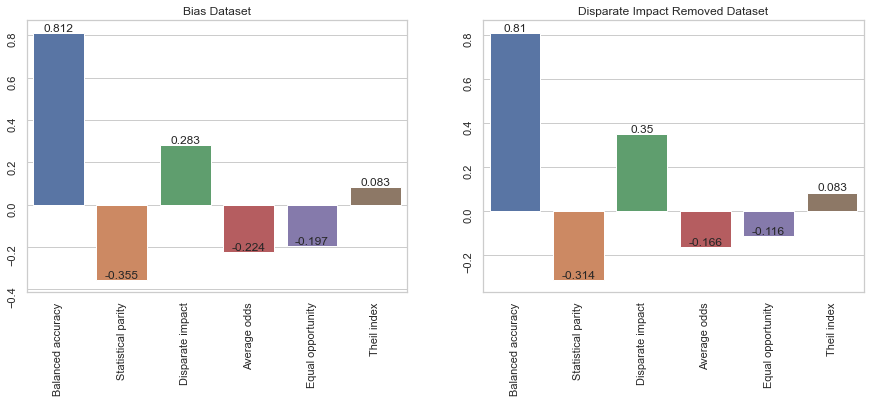

In [22]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

In [23]:
sampled_data = data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.9990
Statistical Parity: -0.0002




### Classification Metrics:

Balanced accuracy: 0.8006
Statistical parity: -0.1932
Disparate impact: 0.5472
Average odds: -0.0339
Equal opportunity: 0.0280
Theil index: 0.0899


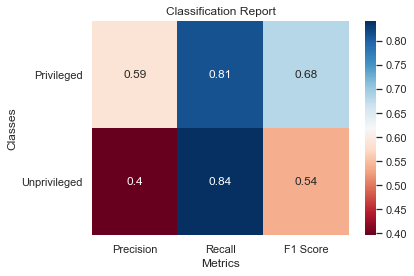

In [24]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


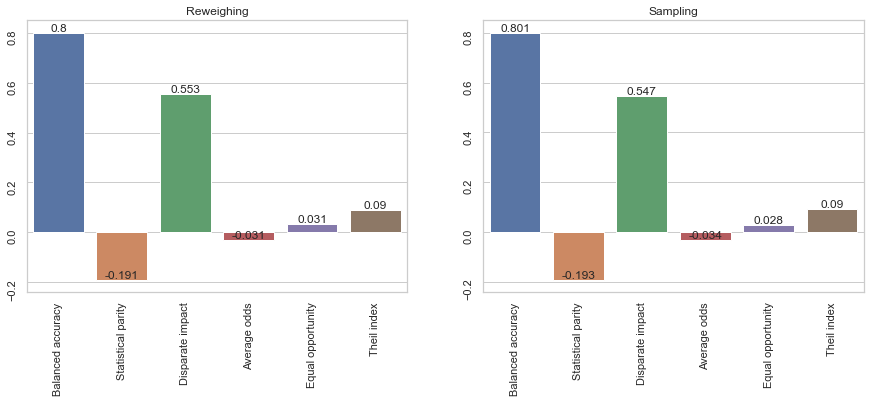

In [25]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.2238,0.8119,0.2829,-0.1971,-0.3550,0.0826
DIR Dataset,-0.1655,0.8103,0.3505,-0.1158,-0.3145,0.0829
Reweighed Dataset,-0.0309,0.8001,0.5532,0.0314,-0.1907,0.0899
Sampled Dataset,-0.0339,0.8006,0.5472,0.0280,-0.1932,0.0899


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


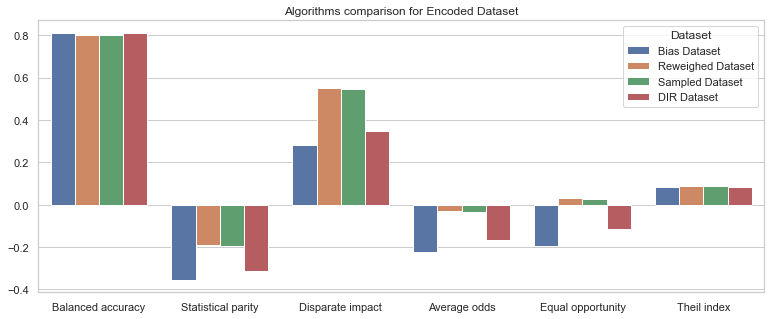

In [26]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighed Dataset': rw_class,
    'Sampled Dataset': sampled_metrics,
    'DIR Dataset': dir_class,
}), "Algorithms comparison for Encoded Dataset")
plt.savefig(os.path.join(path, 'adult_synt.pdf'))
plt.show()

# Test with numerical data

In [27]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


## Bias Dataset

In [28]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7616
Statistical parity: -0.3603
Disparate impact: 0.2360
Average odds: -0.3080
Equal opportunity: -0.3632
Theil index: 0.1090


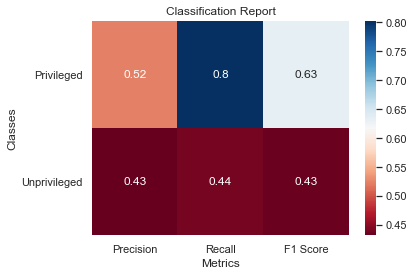

In [29]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin, privileged_group, unprivileged_group)

## Reweighing

In [30]:
rw = Reweighing(unprivileged_group, privileged_group)
df_bin_rw = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7368
Statistical parity: -0.0895
Disparate impact: 0.7652
Average odds: -0.0070
Equal opportunity: -0.0237
Theil index: 0.1207


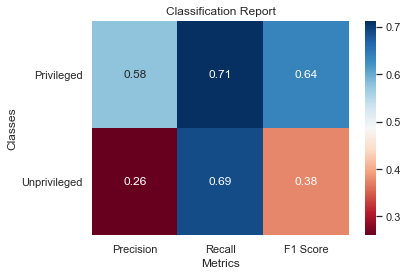

In [31]:
rw_ord_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    df_bin_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


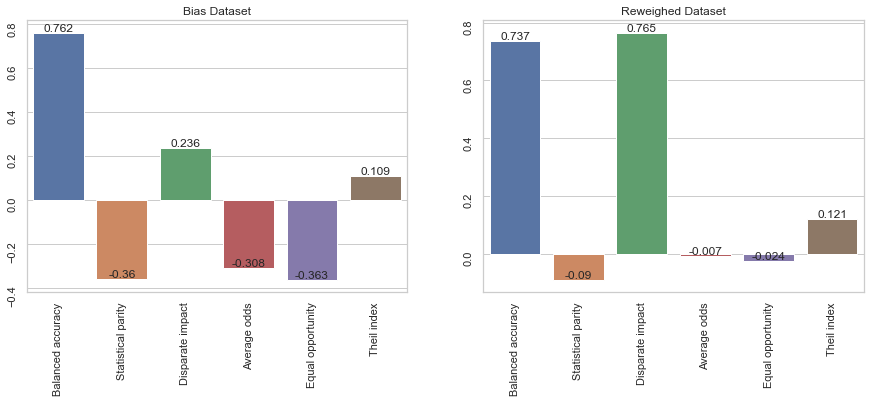

In [32]:
plot_metrics_comparison(df_ord_class, rw_ord_class, 'Bias Dataset', 'Reweighed Dataset')
plt.show()

## DIR

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


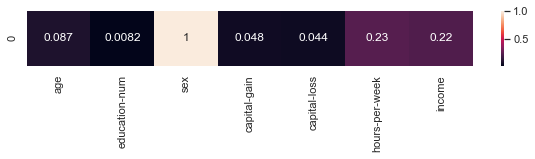

In [33]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


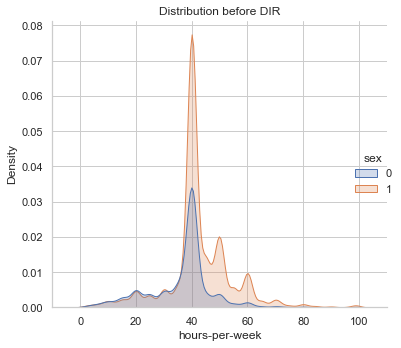

In [34]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_num_bf.pdf')
plt.show()

In [35]:
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [36]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


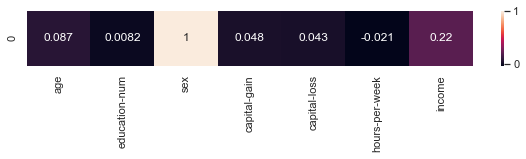

In [37]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


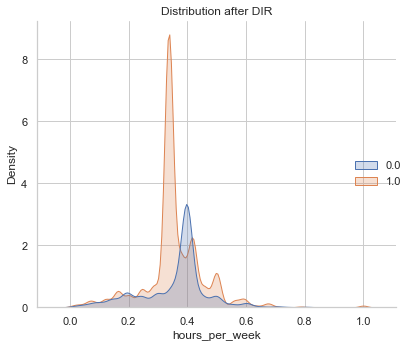

In [38]:
ax = sns.displot(x=df_dir.features[:,5], hue=df_dir.features[:,2], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.tight_layout()
plt.savefig('dir_num_aft.pdf')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7324
Statistical parity: -0.0648
Disparate impact: 0.8273
Average odds: 0.0124
Equal opportunity: -0.0103
Theil index: 0.1224


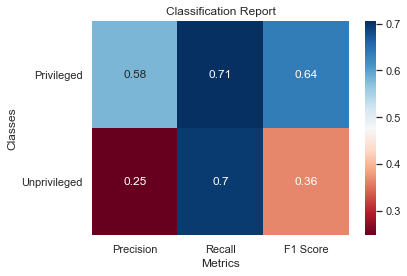

In [39]:
dir_ord_class = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


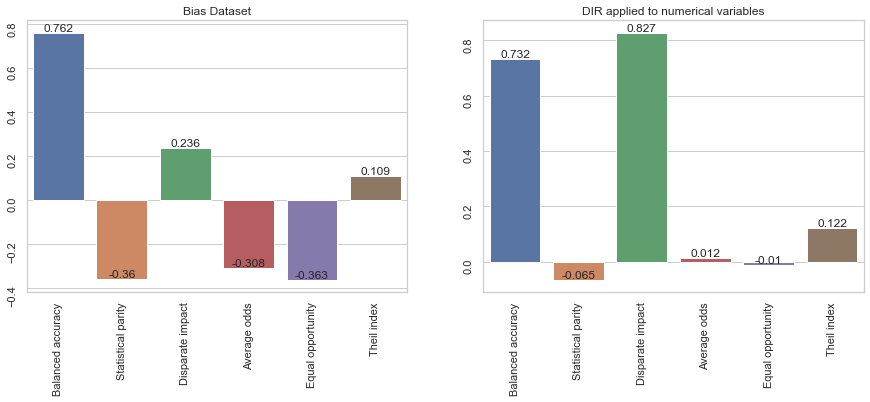

In [40]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Modified Reweighing (Sampling)

In [41]:
sampler = Sampler(round_level=3)
sampled_num = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 0.9989
Statistical Parity: -0.0003




### Classification Metrics:

Balanced accuracy: 0.7368
Statistical parity: -0.0971
Disparate impact: 0.7470
Average odds: -0.0159
Equal opportunity: -0.0335
Theil index: 0.1206


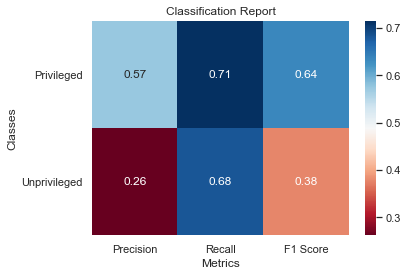

In [42]:
sampled_num_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_num, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


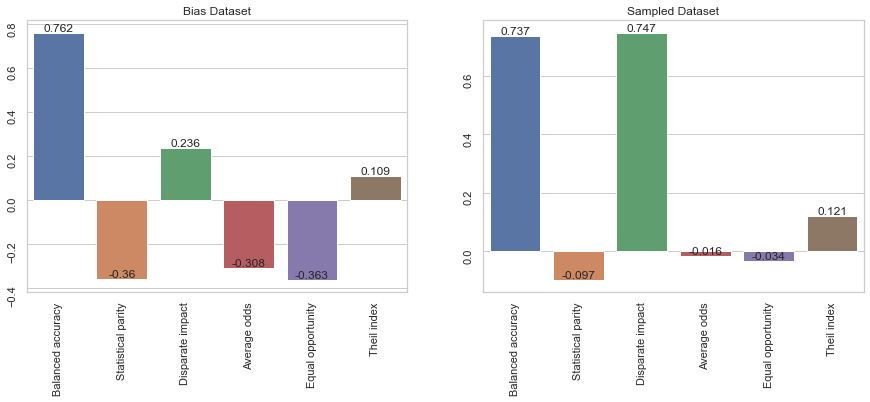

In [43]:
plot_metrics_comparison(df_ord_class, sampled_num_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.3080,0.7616,0.2360,-0.3632,-0.3603,0.1090
DIR Dataset,0.0124,0.7324,0.8273,-0.0103,-0.0648,0.1224
Reweighed Dataset,-0.0070,0.7368,0.7652,-0.0237,-0.0895,0.1207
Sampled Dataset,-0.0159,0.7368,0.7470,-0.0335,-0.0971,0.1206


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


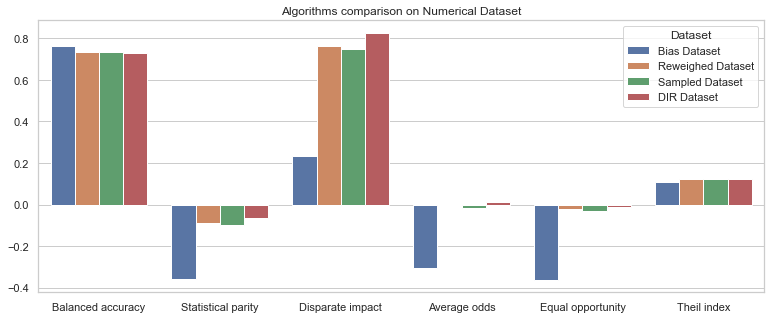

In [44]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df_ord_class,
    'Reweighed Dataset': rw_ord_class,
    'Sampled Dataset': sampled_num_metrics,
    'DIR Dataset': dir_ord_class,
}), 'Algorithms comparison on Numerical Dataset')
plt.savefig(os.path.join(path, 'adult_num_syn.pdf'))
plt.show()

# Reweighing + DIR

## Dataset with One Hot Encoded attributes

In [45]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8034
Statistical parity: -0.2155
Disparate impact: 0.5037
Average odds: -0.0561
Equal opportunity: 0.0059
Theil index: 0.0885


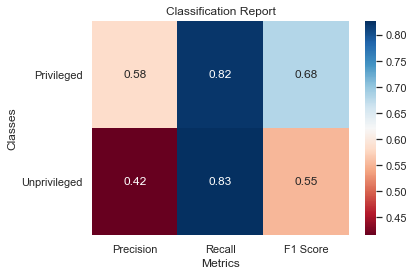

In [46]:
rw_dir_enc_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_enc, privileged_group, unprivileged_group, sensitive_attributes=['sex'], debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


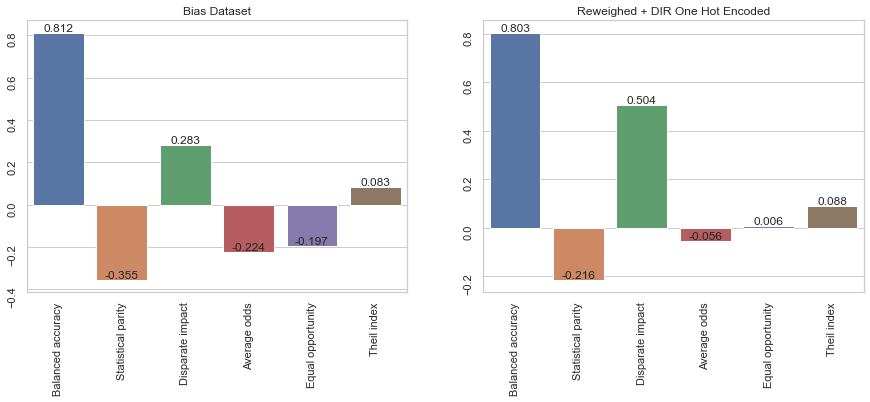

In [47]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

## Dataset with numerical attributes

In [48]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7314
Statistical parity: -0.0589
Disparate impact: 0.8413
Average odds: 0.0228
Equal opportunity: 0.0058
Theil index: 0.1230


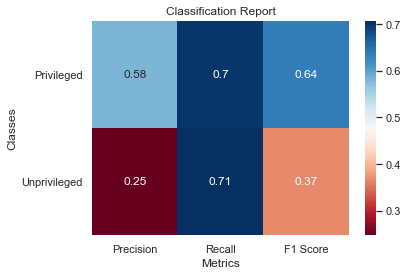

In [49]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'], debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


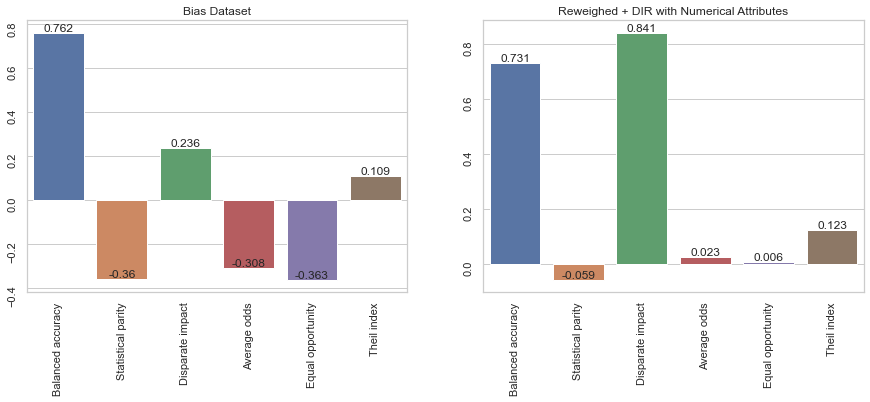

In [50]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

# Algorithms Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset One Hot,-0.2238,0.8119,0.2829,-0.1971,-0.3550,0.0826
Disparate Impact Remover One Hot,-0.1655,0.8103,0.3505,-0.1158,-0.3145,0.0829
Reweighing + DIR One Hot,-0.0561,0.8034,0.5037,0.0059,-0.2155,0.0885
Reweighing One Hot,-0.0309,0.8001,0.5532,0.0314,-0.1907,0.0899
Sampled One Hot,-0.0339,0.8006,0.5472,0.0280,-0.1932,0.0899


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


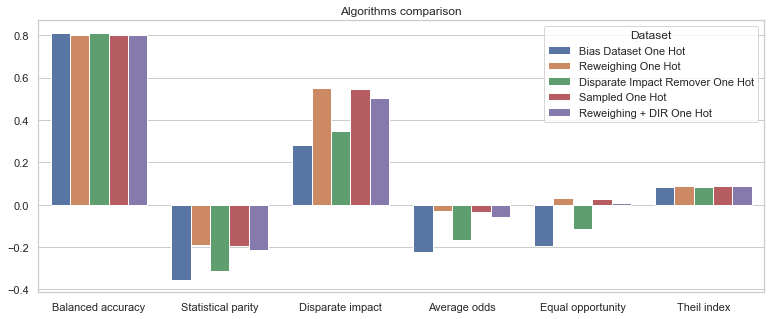

In [51]:
plot_syntesis(merge_datasets({
    'Bias Dataset One Hot': class_metrics,
    'Reweighing One Hot': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Sampled One Hot': sampled_metrics,
    'Reweighing + DIR One Hot': rw_dir_enc_score,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_rw_dir_one_hot.pdf'))
plt.show()

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset Num,-0.3080,0.7616,0.2360,-0.3632,-0.3603,0.1090
Disparate Impact Remover Num,0.0124,0.7324,0.8273,-0.0103,-0.0648,0.1224
Reweighing + DIR Num,0.0228,0.7314,0.8413,0.0058,-0.0589,0.1230
Reweighing Num,-0.0070,0.7368,0.7652,-0.0237,-0.0895,0.1207
Sampled Num,-0.0159,0.7368,0.7470,-0.0335,-0.0971,0.1206


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


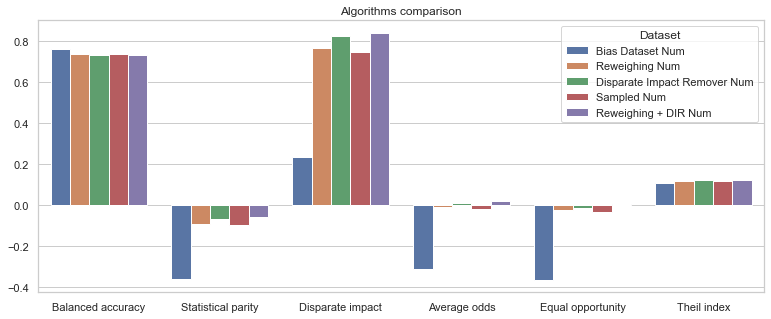

In [52]:
plot_syntesis(merge_datasets({
    'Bias Dataset Num': df_ord_class,
    'Reweighing Num': rw_ord_class,
    'Disparate Impact Remover Num': dir_ord_class,
    'Sampled Num': sampled_num_metrics,
    'Reweighing + DIR Num': rw_dir_score,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_rw_dir_num.pdf'))
plt.show()

# Test Adult with multiple sensitive attributes

## Test with numerical values

In [53]:
df_2 = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country']
df_2.drop(df_2[drop_cols], axis=1, inplace=True)

In [54]:
le = LabelEncoder()
df_2['sex'] = le.fit_transform(df_2['sex'])
df_2['race'] = le.fit_transform(df_2['race'])

In [55]:
perc = (df_2[['sex','race','income']]
            .groupby(['sex','race'])['income']
            .value_counts(normalize=True)
            .rename('Percentage')
            .reset_index())

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


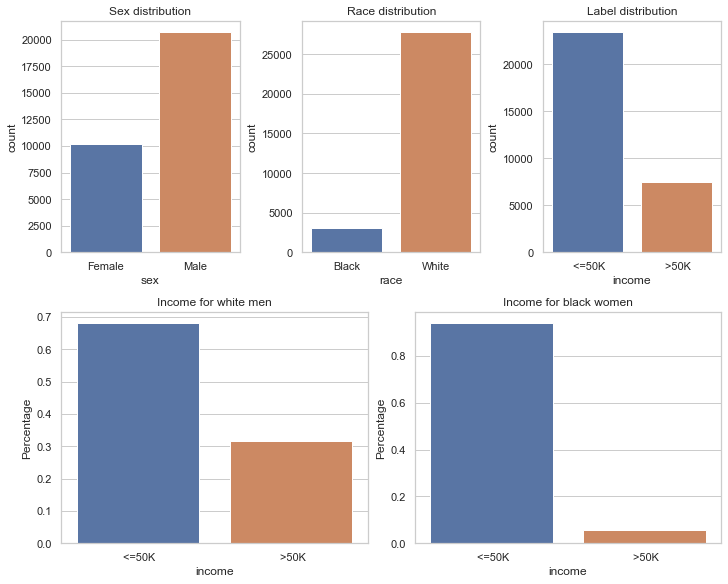

In [56]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
grid = GridSpec(2,6, figure=fig)
ax1 = fig.add_subplot(grid[0,0:2])
ax2 = fig.add_subplot(grid[0,2:4])
ax3 = fig.add_subplot(grid[0,4:])
ax4 = fig.add_subplot(grid[1,0:3])
ax5 = fig.add_subplot(grid[1,3:])
sns.countplot(data=df_2, x='sex', ax=ax1)
sns.countplot(data=df_2, x='race', ax=ax2)
sns.countplot(data=df_2, x='income', ax=ax3)
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='income', y='Percentage', ax=ax4)
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='income', y='Percentage', ax=ax5)
ax1.set_title('Sex distribution')
ax1.set_xticklabels(['Female', 'Male'])
ax2.set_title('Race distribution')
ax2.set_xticklabels(['Black', 'White'])
ax3.set_title('Label distribution')
ax4.set_title('Income for white men')
ax5.set_title('Income for black women')
plt.savefig(os.path.join(path, 'adult_multi_distr.pdf'))
plt.show()

In [57]:
df_2['income'] = le.fit_transform(df_2['income'])

In [58]:
privileged_group = [{'sex': 1, 'race': 1}]
unprivileged_group = [{'sex': 0, 'race': 0}]

## Test on bias dataset

In [59]:
df_2bin = BinaryLabelDataset(df=df_2, protected_attribute_names = ['sex', 'race'], label_names=['income'])

### Dataset Metrics:

Disparate Impact: 0.1823
Statistical Parity: -0.2597




### Classification Metrics:

Balanced accuracy: 0.7617
Statistical parity: -0.4527
Disparate impact: 0.0864
Average odds: -0.3609
Equal opportunity: -0.3982
Theil index: 0.1086


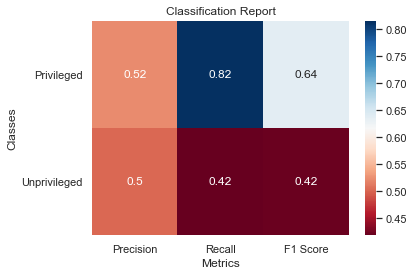

In [60]:
df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_2bin, privileged_group, unprivileged_group)

## Reweighing

In [61]:
rw = Reweighing(unprivileged_group, privileged_group)
df2_rw = df_2bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7493
Statistical parity: -0.2501
Disparate impact: 0.3370
Average odds: -0.1255
Equal opportunity: -0.1255
Theil index: 0.1225


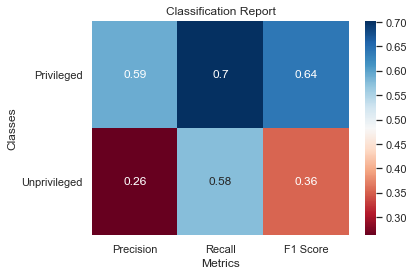

In [62]:
rw_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df2_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


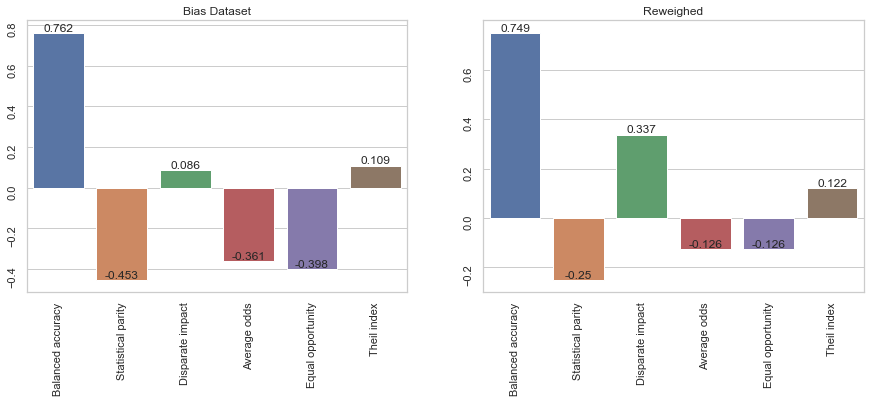

In [63]:
plot_metrics_comparison(df2_class, rw_df2_class, 'Bias Dataset', 'Reweighed')
plt.show()

## Modified Reweighing (Sampling)

In [64]:
sampled2 = df_2bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9868
Statistical Parity: -0.0032




### Classification Metrics:

Balanced accuracy: 0.7362
Statistical parity: -0.1591
Disparate impact: 0.5943
Average odds: -0.0362
Equal opportunity: -0.0370
Theil index: 0.1212


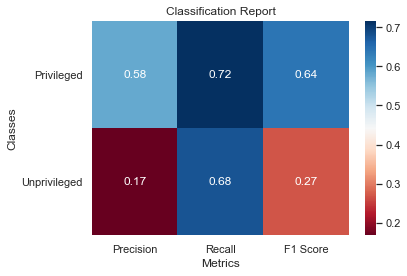

In [65]:
sampled_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled2, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


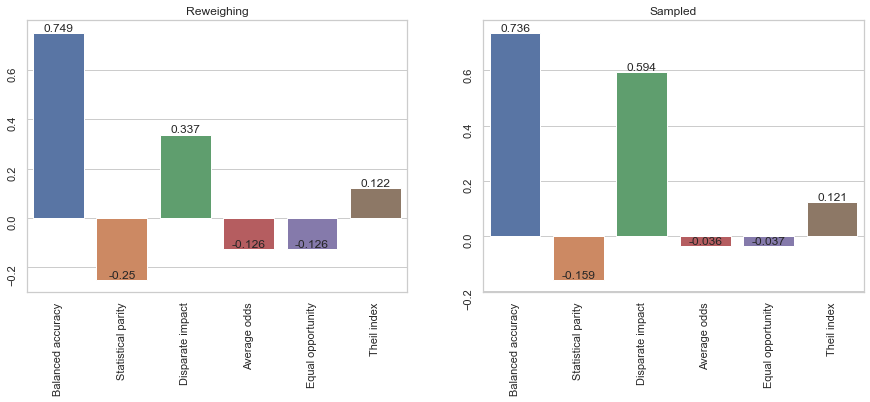

In [66]:
plot_metrics_comparison(rw_df2_class, sampled_df2_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [67]:
dir2 = df_2bin.copy()
scaler = MinMaxScaler(copy=False)
dir2.features = scaler.fit_transform(dir2.features)

In [68]:
df = dir2.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

In [69]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir2 = di.fit_transform(dir2)

In [70]:
df_dir = dir2.convert_to_dataframe()[0]
df_dir.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df_dir.loc[df['prob'].round(6) != 0, 'prob'] = 1
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir2 = BinaryLabelDataset(df = df_dir, label_names=['income'], protected_attribute_names=['prob'])

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

### Dataset Metrics:

Disparate Impact: nan
Statistical Parity: nan




### Classification Metrics:

Balanced accuracy: 0.7290
Statistical parity: nan
Disparate impact: nan
Average odds: nan
Equal opportunity: nan
Theil index: 0.1238


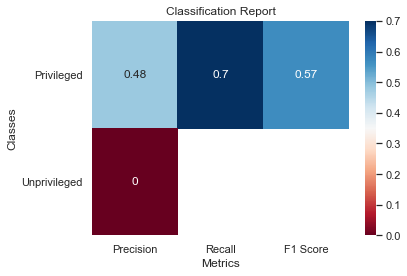

In [71]:
dir_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

## Sampling prob

In [72]:
sampled_prob = BinaryLabelDataset(df=df, label_names=['income'], protected_attribute_names=['prob'])
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9863
Statistical Parity: -0.0033




### Classification Metrics:

Balanced accuracy: 0.7417
Statistical parity: -0.1560
Disparate impact: 0.5621
Average odds: -0.0689
Equal opportunity: -0.0766
Theil index: 0.1188


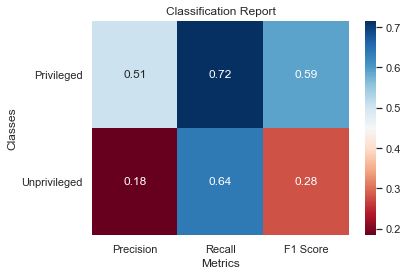

In [73]:
sampled_prob_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_prob, prob_priv_group, prob_unpriv_group, debiaser=sampler, n_splits=5)

## Reweighing + DIR

In [74]:
dir_rw_2 = dir2.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

### Dataset Metrics:

Disparate Impact: nan
Statistical Parity: nan




### Classification Metrics:

Balanced accuracy: 0.7293
Statistical parity: nan
Disparate impact: nan
Average odds: nan
Equal opportunity: nan
Theil index: 0.1238


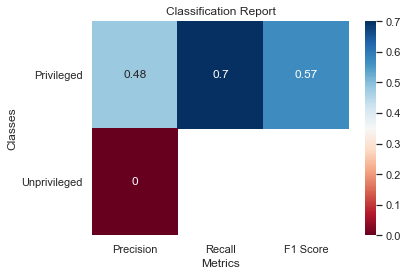

In [75]:
dir_rw_2_class = classify( 
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_rw_2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

## Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.3609,0.7617,0.0864,-0.3982,-0.4527,0.1086
Classic Sampling with prob variable,-0.0689,0.7417,0.5621,-0.0766,-0.1560,0.1188
DIR,NaN,0.7290,NaN,NaN,NaN,0.1238
Extended Sampling,-0.0362,0.7362,0.5943,-0.0370,-0.1591,0.1212
Reweighed,-0.1255,0.7493,0.3370,-0.1255,-0.2501,0.1225
Reweighing + DIR,NaN,0.7293,NaN,NaN,NaN,0.1238


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


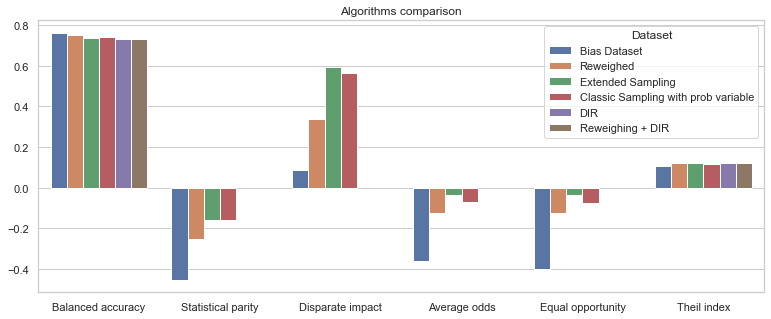

In [76]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df2_class,
    'Reweighed': rw_df2_class,
    'Extended Sampling': sampled_df2_class,
    'Classic Sampling with prob variable': sampled_prob_metrics,
    'DIR': dir_df2_class,
    'Reweighing + DIR': dir_rw_2_class,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_multi_metrics.pdf'))
plt.show()

## Test with encoded variables

In [77]:
df_cat = load_dataset()
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [78]:
df_cat['age_class'] = pd.cut(df_cat['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
df_cat['hour-per-week-class'] = pd.cut(df_cat['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
df_cat.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
df_cat = df_cat.join(pd.get_dummies(df_cat['education'])).drop('education',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['marital-status'])).drop('marital-status',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['occupation'])).drop('occupation',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['relationship'])).drop('relationship',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['native-country'])).drop('native-country',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['age_class'])).drop('age_class',axis=1)
df_cat = df_cat.join(pd.get_dummies(df_cat['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
df_cat['income'] = lab_enc.fit_transform(df_cat['income'])
df_cat[['sex','race']] = ord_enc.fit_transform(df_cat[['sex','race']])

In [79]:
df_cat_bin = BinaryLabelDataset(df=df_cat, protected_attribute_names=['sex','race'], label_names=['income'])

## Bias dataset

### Dataset Metrics:

Disparate Impact: 0.1822
Statistical Parity: -0.2597




### Classification Metrics:

Balanced accuracy: 0.8122
Statistical parity: -0.4314
Disparate impact: 0.1582
Average odds: -0.2721
Equal opportunity: -0.2535
Theil index: 0.0825


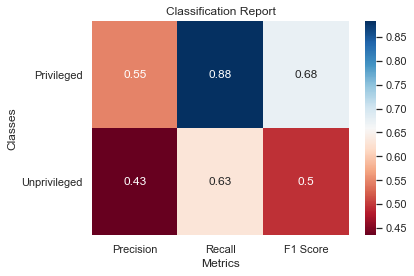

In [80]:
bias_cat2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_cat_bin, privileged_group, unprivileged_group)

## Reweighing

In [81]:
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = df_cat_bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8023
Statistical parity: -0.2859
Disparate impact: 0.3331
Average odds: -0.0709
Equal opportunity: 0.0093
Theil index: 0.0924


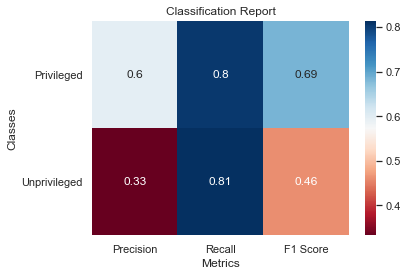

In [82]:
rw_cat2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


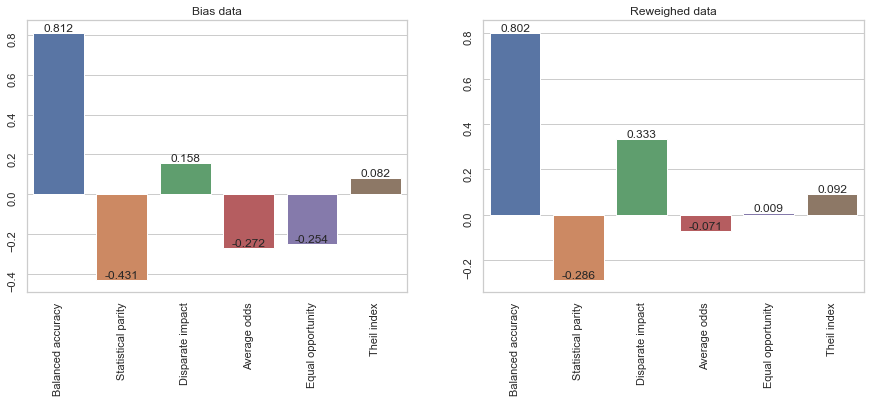

In [83]:
plot_metrics_comparison(bias_cat2_class, rw_cat2_class, 'Bias data', 'Reweighed data')
plt.show()

## Modified Reweighing (Sampling)

In [84]:
sampler = Sampler(round_level=2)
sampled_data = df_cat_bin.copy()

### Dataset Metrics:

Disparate Impact: 0.9866
Statistical Parity: -0.0033




### Classification Metrics:

Balanced accuracy: 0.8002
Statistical parity: -0.2460
Disparate impact: 0.4392
Average odds: -0.0284
Equal opportunity: 0.0560
Theil index: 0.0898


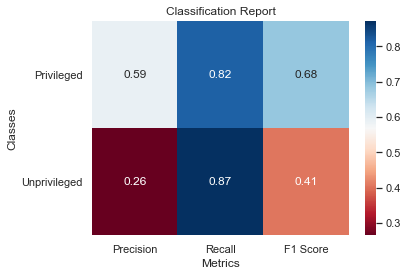

In [85]:
sampled_cat2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


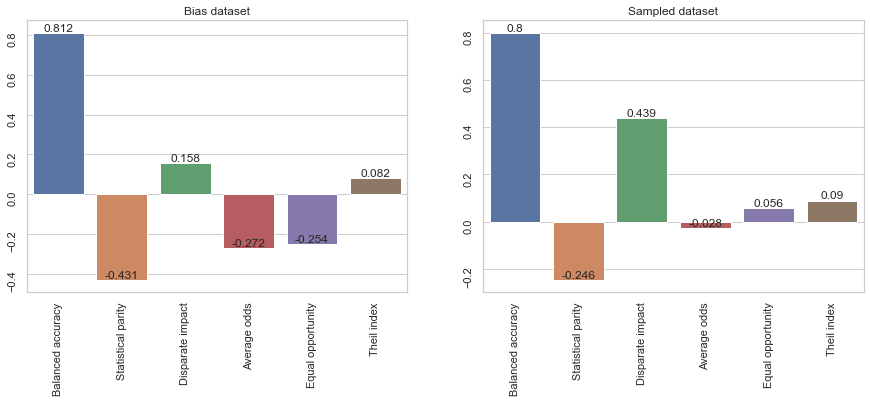

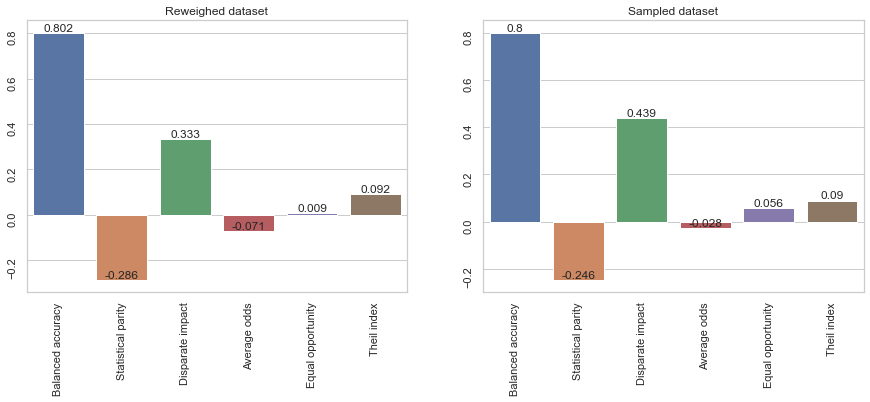

In [86]:
plot_metrics_comparison(bias_cat2_class, sampled_cat2_class, 'Bias dataset', 'Sampled dataset')
plot_metrics_comparison(rw_cat2_class, sampled_cat2_class, 'Reweighed dataset', 'Sampled dataset')
plt.show()

## Disparate Impact Remover

In [87]:
dir_data = df_cat_bin.copy()
scaler = MinMaxScaler()
dir_data.features = scaler.fit_transform(dir_data.features)

In [88]:
df = dir_data.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

df_dir = dir_data.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) == 0.050259, 'prob'] = 0
df_dir.loc[df_dir['prob'].round(6) != 0, 'prob'] = 1
dir_data = BinaryLabelDataset(df = df_dir, label_names=['income'], protected_attribute_names=['prob'])

In [89]:
prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]

### Dataset Metrics:

Disparate Impact: 0.2294
Statistical Parity: -0.1944




### Classification Metrics:

Balanced accuracy: 0.8115
Statistical parity: -0.2915
Disparate impact: 0.2652
Average odds: -0.1590
Equal opportunity: -0.1423
Theil index: 0.0822


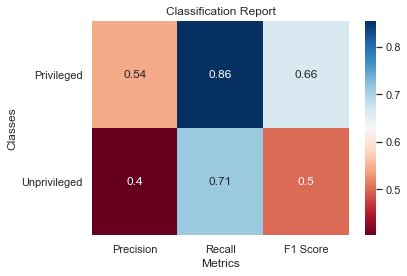

In [90]:
dir_cat2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_data, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


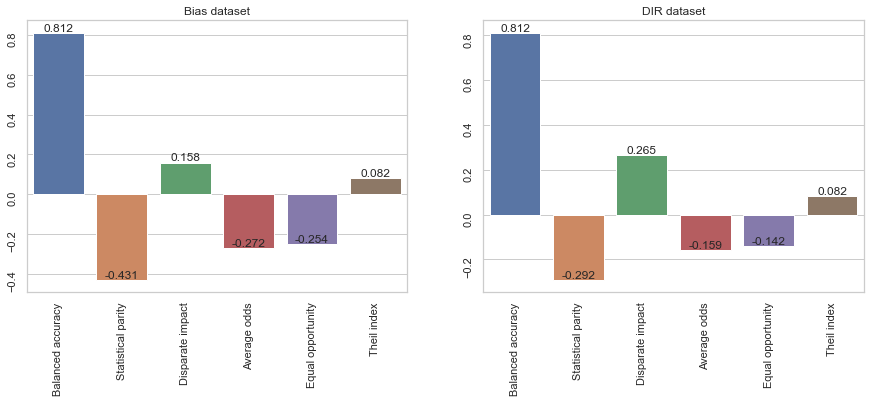

In [91]:
plot_metrics_comparison(bias_cat2_class, dir_cat2_class, 'Bias dataset', 'DIR dataset')
plt.show()

## Sampling prob

In [92]:
sampled_prob = BinaryLabelDataset(df = df_dir, label_names=['income'], protected_attribute_names=['prob'])
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9864
Statistical Parity: -0.0033




### Classification Metrics:

Balanced accuracy: 0.8093
Statistical parity: -0.2102
Disparate impact: 0.4575
Average odds: -0.0588
Equal opportunity: -0.0208
Theil index: 0.0839


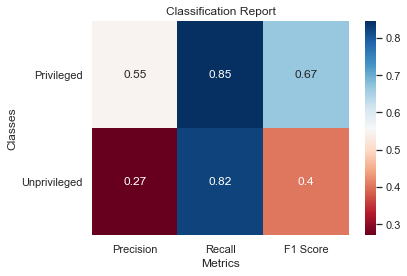

In [93]:
sampled_prob_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_prob, prob_priv_group, prob_unpriv_group, debiaser=sampler, n_splits=5)

## Reweighing + DIR

In [94]:
rw_dir_data = dir_data.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8111
Statistical parity: -0.2817
Disparate impact: 0.2831
Average odds: -0.1337
Equal opportunity: -0.1017
Theil index: 0.0828


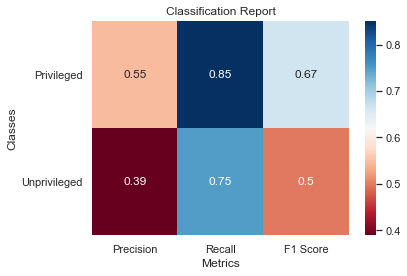

In [95]:
rw_dir_cat2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_data, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

## Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias dataset,-0.2721,0.8122,0.1582,-0.2535,-0.4314,0.0825
Classic sampling with flag variable,-0.0588,0.8093,0.4575,-0.0208,-0.2102,0.0839
DEMV dataset,-0.0284,0.8002,0.4392,0.0560,-0.2460,0.0898
DIR dataset,-0.1590,0.8115,0.2652,-0.1423,-0.2915,0.0822
Reweighed + DIR dataset,-0.1337,0.8111,0.2831,-0.1017,-0.2817,0.0828
Reweighed dataset,-0.0709,0.8023,0.3331,0.0093,-0.2859,0.0924


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


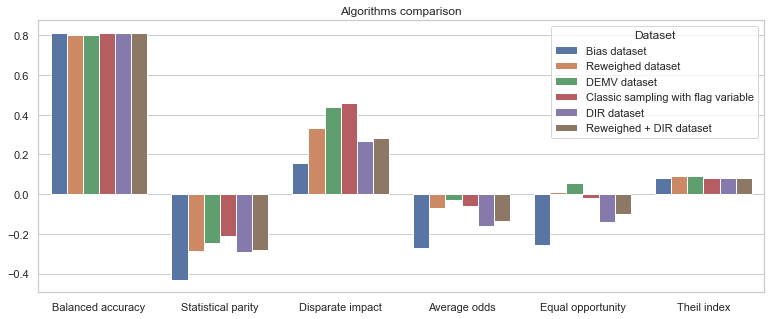

In [96]:
plot_syntesis(merge_datasets({
    'Bias dataset': bias_cat2_class,
    'Reweighed dataset': rw_cat2_class,
    'DEMV dataset': sampled_cat2_class,
    'Classic sampling with flag variable': sampled_prob_metrics,
    'DIR dataset': dir_cat2_class,
    'Reweighed + DIR dataset': rw_dir_cat2_class
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_multi_enc_syn.pdf'))
plt.show()